In [29]:
%reset -sf

In [30]:
!mkdir -p output

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import ortools
import networkx as nx
import graph_tool
import graph_tool.draw

# Input parsing

In [37]:
case_a = "a_an_example.in.txt"
case_b = "b_basic.in.txt"
case_c = "c_coarse.in.txt"
case_d = "d_difficult.in.txt"
case_e = "e_elaborate.in.txt"

folder_in = "input_data/"
folder_out = "output/"

In [38]:
cases = [case_a, case_b, case_c, case_d, case_e]

In [39]:
case = case_a
case = case_b
case = case_c
# case = case_d
# case = case_e

In [40]:
with open(folder_in + case) as f:
    srr = [row.strip() for row in f.readlines()]
    
    arr = [set(x.split()[1:]) for x in srr[1::2]]
    brr = [set(x.split()[1:]) for x in srr[2::2]]

In [41]:
aset = set().union(*arr)
bset = set().union(*brr)
allset = aset | bset

In [42]:
always_include = aset - bset
always_exclude = bset - aset
to_decide = allset - always_include - always_exclude

len(always_include), len(always_exclude), len(to_decide)

(4, 1, 5)

In [43]:
xrr = [x & to_decide for x in arr]
yrr = [x & to_decide for x in brr]

# Data analysis

In [44]:
from collections import Counter
in_counter = Counter()
out_counter = Counter()

for x,y in zip(xrr, yrr):
    in_counter += Counter(x)
    out_counter += Counter(y)

In [45]:
xcount = []
ycount = []
for x in to_decide:
    xcount.append(in_counter[x])
    ycount.append(out_counter[x])

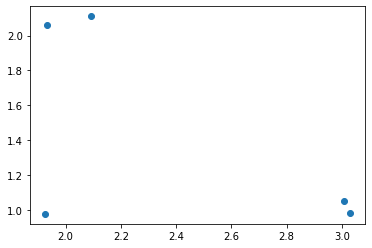

In [46]:
# each datapoint is an ingredient
# x is how many times it is included by a customer
# y is how many times it is excluded by a customer
length = len(xcount)
plt.scatter(np.array(xcount) + np.random.randn(length)/10, 
            np.array(ycount) + np.random.randn(length)/10)
plt.show()

In [47]:
# analyse which pairs of customers cannot be served together
# you can only select customers that are not connected by a vertex

In [48]:
# G = nx.DiGraph()

# for i,(xr1,yr1) in enumerate(zip(xrr, yrr)):
#     G.add_node(i)
#     for j,(xr2,yr2) in enumerate(zip(xrr[i+1:], yrr[i+1:]), start=i+1):
#         if xr1 & yr2 or xr2 & yr1:
#             G.add_edge(i,j)
            
# too slow
# nx.draw(G)

In [49]:
# https://graph-tool.skewed.de/static/doc/quickstart.html
G = graph_tool.Graph(directed=False)
G.add_vertex(len(xrr))

for i,(xr1,yr1) in enumerate(zip(xrr, yrr)):
    for j,(xr2,yr2) in enumerate(zip(xrr[i+1:], yrr[i+1:]), start=i+1):
        if xr1 & yr2 or xr2 & yr1:
            G.add_edge(i,j)

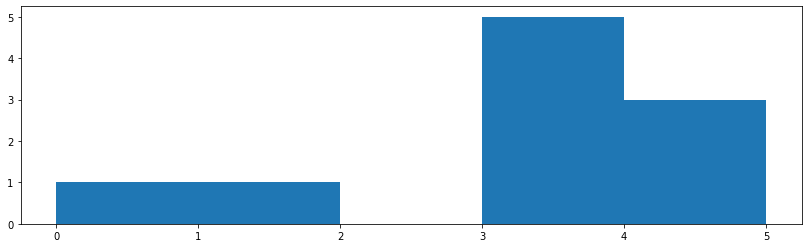

In [50]:
plt.figure(figsize=(14,4))
degrees = G.get_total_degrees(G.get_vertices())
plt.hist(degrees, bins=range(0, int(max(degrees)) + 2))
plt.show()

In [51]:
import graph_tool.topology

In [52]:
comp, hist = graph_tool.topology.label_components(G)

In [53]:
# There is one large connected graph
Counter(hist)

Counter({9: 1, 1: 1})

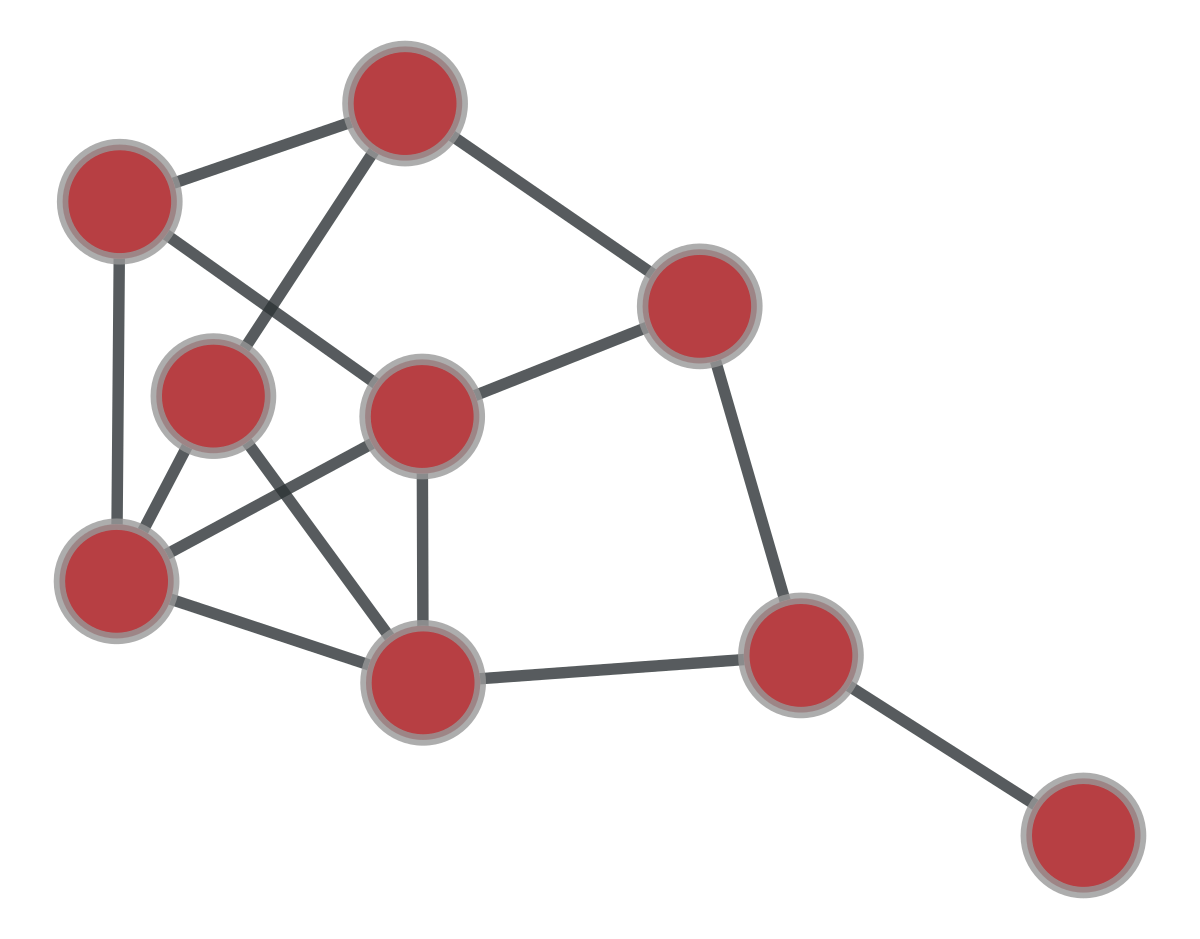

In [54]:
# pretty messy when large

for idx in reversed(sorted(G.get_vertices())):
    if G.vertex(idx).out_degree() > 7:
        G.remove_vertex(idx)

for idx in reversed(sorted(G.get_vertices())):
    if G.vertex(idx).out_degree() == 0:
        G.remove_vertex(idx)

# pos = graph_tool.draw.random_layout(G)
graph_tool.draw.graph_draw(G)
plt.show()

# Upper bound analysis

In [23]:
# see Codeforces comment
# probably not gonna do for this practice
# also unlikely to do such complicated analysis in qualifiers

# Scoring

In [24]:
def scoring(crr):
    crr = set(crr)
    res = 0
    for a,b in zip(arr,brr):
        
        all_included = set(a) & crr == set(a)
        all_excluded = set(b) & crr == set()

        if all_included and all_excluded:
            res += 1
    return res

scoring(list(always_include))

1420

In [25]:
res = list(always_include)

# Submission

In [27]:
import shutil

def save_file(res):
    shutil.copy("adhoc.ipynb", folder_out)
    score = str(scoring(res)).zfill(10)
    with open(folder_out + case + score, "w") as f:
        f.write(str(len(res)) + " " + " ".join(res))
        
save_file(res)

# 1-opt

Idea - force to serve a customer

In [28]:
!ls output

adhoc.ipynb                  d_difficult.in.txt0000001420


In [26]:
# initialisation
crr = always_include

In [27]:
# loads an input

score = '0000001707'
filename = case + score
with open(folder_out + case + score) as f:
    crr = f.read().split()[1:]

In [28]:
prev_points, pts = scoring(crr), 0
crr = set(crr)

while True:
    idx = np.random.randint(0,len(xrr)-1)
    
    if xrr[idx] & crr == xrr[idx] and not yrr[idx] & crr:
        continue
    new_crr = (crr | xrr[idx]) - yrr[idx]
    
    pts = scoring(new_crr)
    if pts > prev_points:
        crr = new_crr
        prev_points = pts
        print(pts)

1708
1710
1711
1712
1713
1715
1716
1718
1719
1721
1722
1723
1725
1726
1727
1729
1730
1731
1732
1733
1735
1736
1739
1740
1742
1743
1745
1746
1747
1748
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1763
1764
1765


KeyboardInterrupt: 

In [29]:
res = crr
save_file(res)

# 2-opt
Force to serve two customers

In [30]:
crr = set(crr)
prev_points, pts = scoring(crr), 0
# del idx

while True:
    idx1 = np.random.randint(0,len(xrr)-1)
    idx2 = np.random.randint(0,len(xrr)-1)
    
    if xrr[idx1] & yrr[idx2]:
        continue
    if xrr[idx2] & yrr[idx1]:
        continue
    if xrr[idx1] & crr == xrr[idx1] and not yrr[idx1] & crr:
        continue
    if xrr[idx2] & crr == xrr[idx2] and not yrr[idx2] & crr:
        continue
    
    new_crr = (crr | xrr[idx1] | xrr[idx2]) - yrr[idx1] - yrr[idx2]
    
    pts = scoring(new_crr)
    if pts > prev_points:
        crr = new_crr
        prev_points = pts
        print(pts)

1766
1767
1768
1769
1770
1771
1772
1773
1774
1776
1777


KeyboardInterrupt: 

In [31]:
res = crr
save_file(res)

# Integer Programming
Likely totally useless in actual contest.

In [32]:
from ortools.linear_solver import pywraplp
solver = pywraplp.Solver.CreateSolver('SCIP')


In [34]:
ingredients = {x:solver.IntVar(0, 1, x) for x in to_decide}

targets = []
for i,(xr,yr) in enumerate(zip(xrr, yrr)):
    satisfied = solver.IntVar(0, 1, str(i).zfill(6))
    
    # all included ingredients
    if xr:
        solver.Add(len(xr) - sum(ingredients[x] for x in xr) <= (1 - satisfied) * (len(xr)))
    
    # all excluded ingredients 
    if yr:
        solver.Add(sum(ingredients[y] for y in yr) <= (1 - satisfied) * (len(yr)))
    targets.append(satisfied)

solver.SetTimeLimit(60*1000)
solver.Maximize(sum(targets))

In [35]:
status = solver.Solve()

In [36]:
if status == pywraplp.Solver.OPTIMAL:
    print('Solution:')
    print('Objective value =', solver.Objective().Value())
else:
    print('The problem does not have an optimal solution.')

print('\nAdvanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations' % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())

The problem does not have an optimal solution.

Advanced usage:
Problem solved in 66467.000000 milliseconds
Problem solved in 36196 iterations
Problem solved in 14 branch-and-bound nodes


In [37]:
res = [k for k,v in ingredients.items() if v.solution_value() == 1]
res = set(res) | always_include

print(scoring(res))
save_file(res)

1707
